In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

np.random.seed(42)

users = pd.read_csv("datadesign/users.csv")
channels = pd.read_csv("datadesign/channel_exposure.csv")


In [46]:
df = users.merge(channels, on="user_id")
df.head()


,user_id,age,income_band,risk_score,channel_x,converted,channel_y,exposed,cost
0,0,56,low,0.404887,social_ads,0,social_ads,1,1.777098
1,1,46,low,0.271536,affiliate,1,affiliate,1,2.191188
2,2,32,low,0.360160,paid_search,0,paid_search,1,3.052957
3,3,60,low,0.407633,social_ads,1,social_ads,1,1.650550
4,4,25,mid,0.556474,organic,1,organic,1,0.175349


In [47]:
df.groupby("channel_x")["converted"].mean().sort_values(ascending=False)


channel_x
referral       0.624478
affiliate      0.605584
paid_search    0.592862
social_ads     0.501167
organic        0.433998
Name: converted, dtype: float64

In [48]:
TARGET_CHANNEL = "paid_search"

df["treatment"] = (df["channel_x"] == TARGET_CHANNEL).astype(int)


In [49]:
features = ["age", "risk_score"]
X = df[features]
y = df["converted"]
T = df["treatment"]


In [50]:
X_treat = X[T == 1]
y_treat = y[T == 1]

X_control = X[T == 0]
y_control = y[T == 0]

model_treat = XGBClassifier(
    max_depth=3,
    n_estimators=200,
    learning_rate=0.05,
    subsample=0.8,
    eval_metric="logloss"
)

model_control = XGBClassifier(
    max_depth=3,
    n_estimators=200,
    learning_rate=0.05,
    subsample=0.8,
    eval_metric="logloss"
)

model_treat.fit(X_treat, y_treat)
model_control.fit(X_control, y_control)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [51]:
p_treat = model_treat.predict_proba(X)[:, 1]
p_control = model_control.predict_proba(X)[:, 1]

df["uplift"] = p_treat - p_control


In [52]:
df["uplift"].describe()

count    50000.000000
mean         0.027381
std          0.039306
min         -0.177277
25%          0.005648
50%          0.028994
75%          0.050359
max          0.177586
Name: uplift, dtype: float64

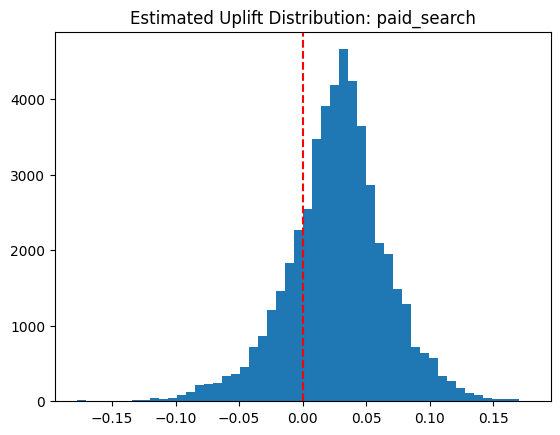

In [53]:
plt.hist(df["uplift"], bins=50)
plt.axvline(0, color="red", linestyle="--")
plt.title(f"Estimated Uplift Distribution: {TARGET_CHANNEL}")
plt.show()


In [54]:
df["conversion_rate"] = y

comparison = (
    df.groupby("channel_x")
    .agg(
        avg_conversion=("conversion_rate", "mean"),
        avg_uplift=("uplift", "mean")
    )
    .sort_values("avg_uplift", ascending=False)
)

comparison


,avg_conversion,avg_uplift
channel_x,,
paid_search,0.592862,0.028295
affiliate,0.605584,0.027917
referral,0.624478,0.027816
organic,0.433998,0.027492
social_ads,0.501167,0.026076


In [55]:
df.groupby("channel_x")["uplift"].mean()


channel_x
affiliate      0.027917
organic        0.027492
paid_search    0.028295
referral       0.027816
social_ads     0.026076
Name: uplift, dtype: float32

In [56]:
results = []

for channel in df["channel_x"].unique():
    df["treatment"] = (df["channel_x"] == channel).astype(int)

    X = df[features]
    y = df["converted"]
    T = df["treatment"]

    model_t = XGBClassifier(max_depth=3, n_estimators=150, learning_rate=0.05)
    model_c = XGBClassifier(max_depth=3, n_estimators=150, learning_rate=0.05)

    model_t.fit(X[T == 1], y[T == 1])
    model_c.fit(X[T == 0], y[T == 0])

    uplift = (
        model_t.predict_proba(X)[:, 1]
        - model_c.predict_proba(X)[:, 1]
    )

    results.append({
        "channel": channel,
        "mean_uplift": uplift.mean()
    })

uplift_summary = pd.DataFrame(results).sort_values("mean_uplift", ascending=False)
uplift_summary


,channel,mean_uplift
4,referral,0.056210
1,affiliate,0.039749
2,paid_search,0.027333
0,social_ads,-0.025108
3,organic,-0.101457


In [57]:
comparison = comparison.reset_index()[['channel_x','avg_conversion']].copy()
comparison = comparison.merge(uplift_summary, left_on='channel_x', right_on = 'channel', how = 'inner')

In [58]:
comparison.drop(columns = 'channel_x')[['channel', 'avg_conversion', 'mean_uplift']]

,channel,avg_conversion,mean_uplift
0,paid_search,0.592862,0.027333
1,affiliate,0.605584,0.039749
2,referral,0.624478,0.056210
3,organic,0.433998,-0.101457
4,social_ads,0.501167,-0.025108


In [59]:
df

,user_id,age,income_band,risk_score,channel_x,converted,channel_y,exposed,cost,treatment,uplift,conversion_rate
0,0,56,low,0.404887,social_ads,0,social_ads,1,1.777098,0,-0.042967,0
1,1,46,low,0.271536,affiliate,1,affiliate,1,2.191188,0,0.024612,1
2,2,32,low,0.360160,paid_search,0,paid_search,1,3.052957,0,0.085478,0
3,3,60,low,0.407633,social_ads,1,social_ads,1,1.650550,0,-0.022671,1
4,4,25,mid,0.556474,organic,1,organic,1,0.175349,0,0.054585,1
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,60,low,0.317065,affiliate,1,affiliate,1,2.497546,0,0.040557,1
49996,49996,46,mid,0.522092,social_ads,0,social_ads,1,2.194286,0,0.078485,0
49997,49997,19,high,0.653547,referral,0,referral,1,0.906071,1,-0.013701,0
49998,49998,43,low,0.600898,organic,0,organic,1,0.205755,0,0.058122,0


In [60]:
df.to_csv('datadesign/uplift_results.csv', index=False)